In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
from desc import set_device
set_device("gpu")

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

print_backend_info()

DESC version=0.14.2+167.ga620ee5d8.
Using JAX backend: jax version=0.6.0, jaxlib version=0.6.0, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.03 GB available memory.


In [9]:
eq = get("HELIOTRON")
# res = 12
# eq = Equilibrium(L=res, M=res, N=res, sym=False)
obj = ObjectiveFunction(ForceBalance(eq))
cons = get_fixed_boundary_constraints(eq)
cons = maybe_add_self_consistency(eq, cons)
con = ObjectiveFunction(cons)
objective = LinearConstraintProjection(obj, con)
objective.build()

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency


In [10]:
J = objective.jac_scaled_error(objective.x(eq))

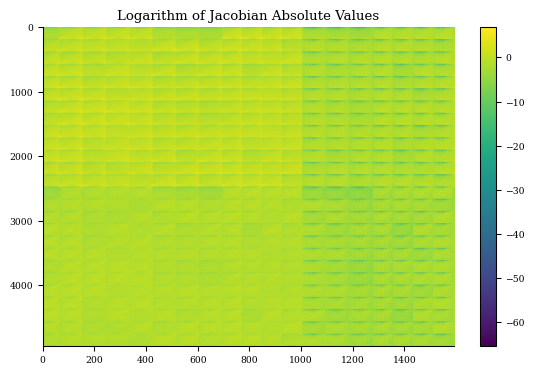

In [13]:
plt.imshow(jnp.log(jnp.abs(J)), cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Logarithm of Jacobian Absolute Values")
plt.savefig("abs-log-jacobian.png", dpi=2000)

In [12]:
J = objective.jac_scaled_error(objective.x(eq))
# Jfull = obj.jac_scaled_error(obj.x(eq))
print(f"{jnp.linalg.cond(J):.2e}")
# print(f"{jnp.linalg.cond(Jfull[:, :(eq.R_lmn.size + eq.Z_lmn.size + eq.L_lmn.size)]):.2e}")

2.23e+07


In [22]:
J = objective.jac_unscaled(objective.x(eq))
Jfull = obj.jac_unscaled(obj.x(eq))
print(f"{jnp.linalg.cond(J):.2e}")
print(f"{jnp.linalg.cond(Jfull[:, :(eq.R_lmn.size + eq.Z_lmn.size + eq.L_lmn.size)]):.2e}")

1.85e+08
1.28e+09


1977


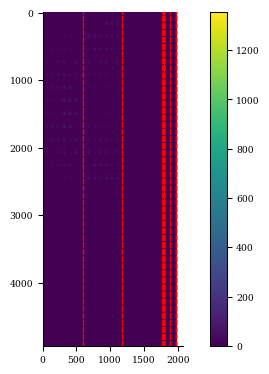

In [ ]:
Jfull = jnp.abs(Jfull)
plt.imshow(Jfull)
plt.colorbar()
size_total = 0
# Add vertical lines to divide up the horizontal axis into parameters
for key, value in eq.params_dict.items():
    size = value.size
    size_total += size
    plt.axvline(x=size_total, color='r', linestyle='--')
plt.savefig("jacobian_full.png", dpi=2000)

In [14]:
Jfull = jnp.abs(Jfull)
size_total = 0
# Add vertical lines to divide up the horizontal axis into parameters
for key, value in eq.params_dict.items():
    size = value.size
    if size !=0:
        print(key, jnp.max(Jfull[:, size_total:size_total+size]))
    size_total += size

R_lmn 1352.5996302653657
Z_lmn 1106.2189233451327
L_lmn 16.17889054268075
p_l 2.9224282347387985e-06
i_l 0.04331540107744627
Psi 0.03782182970961983
Ra_n 0.0
Za_n 0.0
Rb_lmn 0.0
Zb_lmn 0.0


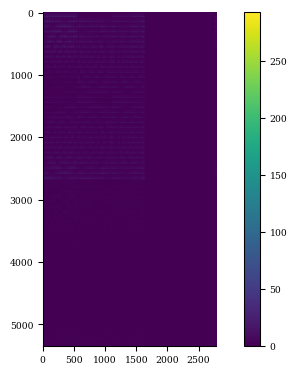

In [8]:
J = jnp.abs(J)
plt.imshow(J)
plt.colorbar()
plt.savefig("jacobian.png", dpi=2000)

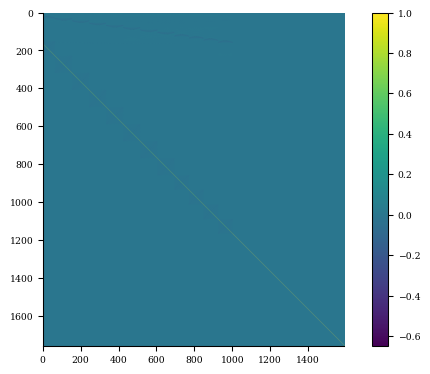

In [17]:
plt.imshow(objective._Z)
plt.colorbar()
jnp.linalg.cond(objective._Z)
plt.savefig("nullspace.png", dpi=2000)